# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Homework 6 - RNNs



**Harvard University**<br/>
**Fall 2020**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, & Chris Tanner


<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

<span style="color:red">**Model training can be very slow; start doing this HW early**</span>

- To submit your assignment follow the instructions given in Canvas.

- This homework can be submitted in pairs.

- If you submit individually but you have worked with someone, please include the name of your **one** partner below.
- Please restart the kernel and run the entire notebook again before you submit.

**Names of person you have worked with goes here:**
<br><BR>

<div class="theme"> Overview: Named Entity Recognition Challenge</div>

Named entity recognition (NER) seeks to locate and classify named entities present in unstructured text into predefined categories such as organizations, locations, expressions of times, names of persons, etc. This technique is often used in real use cases such as classifying content for news providers, efficient search algorithms over large corpora and content-based recommendation systems. 

This represents an interesting "many-to-many" problem, allowing us to experiment with recurrent architectures and compare their performances against other models.


In [2]:
import pandas as pd
import numpy as np

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [3]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend

from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Input, SimpleRNN, Embedding, Dense, TimeDistributed, GRU, \
                          Dropout, Bidirectional, Conv1D, BatchNormalization

print(tf.keras.__version__)
print(tf.__version__)

2.2.4-tf
2.0.0


In [4]:
# Set seed for repeatable results
np.random.seed(123)
tf.random.set_seed(456)

<div class="theme"> Part 1: Data </div>
Read `HW6_data.csv` into a pandas dataframe using the provided code below.

In [5]:
# Given code
path_dataset = './data/HW6_data.csv'
data = pd.read_csv(path_dataset,
                   encoding="latin1")
data = data.fillna(method="ffill")
data.head(15)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


As you can see, we have a dataset with sentences (```Sentence #``` column), each composed of words (```Word``` column) with part-of-speech tagging (```POS``` tagging) and inside–outside–beginning (IOB) named entity tags (```Tag``` column) attached. ```POS``` will not be used for this homework. We will predict ```Tag``` using only the words themselves.

Essential info about entities:
* geo = Geographical Entity
* org = Organization
* per = Person
* gpe = Geopolitical Entity
* tim = Time indicator
* art = Artifact
* eve = Event
* nat = Natural Phenomenon

IOB prefix:
* B: beginning of named entity
* I: inside of named entity
* O: outside of named entity


<div class='exercise'><b> Question 1: Data [20 points total]</b></div>

**1.1** Create a list of unique words found in the 'Word' column and sort it in alphabetic order. Then append the special word "ENDPAD" to the end of the list, and assign it to the variable ```words```. Store the length of this list as ```n_words```. **Print your results for `n_words`**

**1.2** Create a list of unique tags and sort it in alphabetic order. Then append the special word "PAD" to the end of the list, and assign it to the variable ```tags```. Store the length of this list as ```n_tags```. **Print your results for `n_tags`**

**1.3** Process the data into a list of sentences where each sentence is a list of (word, tag) tuples. Here is an example of how the first sentence in the list should look:

[('Thousands', 'O'),
 ('of',  'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]
 
**1.4** Find out the number of words in the longest sentence, and store it to variable ```max_len```. **Print your results for `max_len`.**

**1.5** It's now time to convert the sentences data in a suitable format for the RNNs training/evaluation procedures. Create a ```word2idx``` dictionary mapping distinct words from the dataset into distinct integers. Also create a ```idx2word``` dictionary.

**1.6** Prepare the predictors matrix ```X```, as a list of lists, where each inner list is a sequence of words mapped into integers accordly to the ```word2idx``` dictionary. 

**1.7** Apply the keras ```pad_sequences``` function to standardize the predictors. You should retrieve a matrix with all padded sentences and length equal to ```max_len``` previously computed. The dimensionality should therefore be equal to ```[# of sentences, max_len]```. Run the provided cell to print your results. Your ```X[i]``` now should be something similar to this:

`[ 8193 27727 31033 33289 22577 33464 23723 16665 33464 31142 31319 28267
 27700 33246 28646 16052    21 16915 17349  7924 32879 32985 18238 23555
    24 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178]`
 
**1.8** Create a ```tag2idx``` dictionary mapping distinct named entity tags from the dataset into distinct integers. Also create a ```idx2tag``` dictionary.

**1.9** Prepare targets matrix ```Y```, as a list of lists,where each inner list is a sequence of tags mapped into integers accordly to the ```tag2idx``` dictionary.

**1.10** apply the keras ```pad_sequences``` function to standardize the targets. Inject the ```PAD``` tag for the padding words. You should retrieve a matrix with all padded sentences'tags and length equal to ```max_length``` previously computed. 

**1.11** Use the ```to_categorical``` keras function to one-hot encode the tags. Now your ```Y``` should have dimension ```[# of sentences, max_len, n_tags]```. Run the provided cell to print your results.

**1.12** Split the dataset into train and test sets (test 10%).

## Answers

**1.1** Create a list of unique words found in the 'Word' column and sort it in alphabetic order. Then append the special word "ENDPAD" to the end of the list, and assign it to the variable ```words```. Store the length of this list as ```n_words```. **Print your results for `n_words`**

In [6]:
word_extract = list(data.Word)
words = list(set(word_extract))
words.sort()
words.append("ENDPAD")
n_words = len(words)

In [7]:
# Run this cell to show your results for n_words
print(n_words)

35179


**1.2** Create a list of unique tags and sort it in alphabetic order. Then append the special word "PAD" to the end of the list, and assign it to the variable ```tags```. Store the length of this list as ```n_tags```. **Print your results for `n_tags`**

In [8]:
tag_extract = list(data.Tag)
tags = list(set(tag_extract))
tags.sort()
tags.append("PAD")
n_tags = len(tags)

In [9]:
# Run this cell to show your results for n_tags
print(n_tags)

18


**1.3** Process the data into a list of sentences where each sentence is a list of (word, tag) tuples. Here is an example of how the first sentence in the list should look:

[('Thousands', 'O'),
 ('of',  'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]
 

In [10]:
data['word_tag'] = list(zip(data.Word, data.Tag))
data.head()

,Sentence #,Word,POS,Tag,word_tag
0,Sentence: 1,Thousands,NNS,O,"(Thousands, O)"
1,Sentence: 1,of,IN,O,"(of, O)"
2,Sentence: 1,demonstrators,NNS,O,"(demonstrators, O)"
3,Sentence: 1,have,VBP,O,"(have, O)"
4,Sentence: 1,marched,VBN,O,"(marched, O)"


In [11]:
sent_tag_list = data.word_tag.groupby(data['Sentence #']).apply(list)
print(f'Length of the list: {len(sent_tag_list)}\n')
print(f'First sentence:\n {(sent_tag_list[0])}')

Length of the list: 47959

First sentence:
 [('Thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('London', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('Iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('British', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


In [12]:
# list of tags; tags
tags_temp = ['irrel', 'TAG_ONE', 'TAG_ONE', 'TAG_TWO', 'TAG_ONE', 'TAG_TWO', 'irrel']

# values for tagging; words
vals_temp = ['not_rel', 1, 2, 5, 3, 6, 'not_rel']

# subset of tags for dictionary creation
sent_tags_temp = ['TAG_ONE', 'TAG_TWO']

# desired output
tags_dict0 = {'TAG_ONE': [1, 2, 3], 'TAG_TWO': [5, 6]}

In [13]:
tag1 = {}

for sent_tag in sent_tags_temp:
    val_list = []
    
    for ind, tag in enumerate(tags_temp):
        if tags_temp[ind] == sent_tag: # if tag == sent_tag
            val_list.append(vals_temp[ind])
    
    tag1.update({sent_tag : val_list})
tag1

{'TAG_ONE': [1, 2, 3], 'TAG_TWO': [5, 6]}

In [14]:
#{sent_tag : [vals[ind] for ind, tag in enumerate(tags) if tags[ind] == sent_tag] for sent_tag in sent_tags}

In [15]:
# your code here
word_tag = list(zip(data.Word, data.Tag))
word_tag[:4]

[('Thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O')]

In [16]:
type(word_tag[4]), type(word_tag[0][1])

(tuple, str)

In [17]:
print(word_tag[444][1])

I-per


In [18]:
word_tag_list0 = []

for tag in tags:
    #print(tag)
    new_tag_list = []
    for i in range(len(word_tag)):
        
        if word_tag[i][1] == tag:
            new_tag_list.append(word_tag)
    
    word_tag_list0.append(new_tag_list)

In [19]:
sumval0 = 0
lenval0 = []
for i in range(len(word_tag_list0)):
    sumval0 += len(word_tag_list0[i])
    lenval0.append(len(word_tag_list0[i]))

print(sumval0, lenval0)

1048575 [402, 308, 37644, 15870, 201, 20143, 16990, 20333, 297, 253, 7414, 198, 51, 16784, 17251, 6528, 887908, 0]


In [20]:
print(data.shape)
data.head(n=3)

(1048575, 5)


,Sentence #,Word,POS,Tag,word_tag
0,Sentence: 1,Thousands,NNS,O,"(Thousands, O)"
1,Sentence: 1,of,IN,O,"(of, O)"
2,Sentence: 1,demonstrators,NNS,O,"(demonstrators, O)"


In [21]:
data['Sentence #'].value_counts()

Sentence: 22480    104
Sentence: 33481     81
Sentence: 40153     73
Sentence: 21167     72
Sentence: 21776     70
                  ... 
Sentence: 22065      2
Sentence: 37093      2
Sentence: 39874      2
Sentence: 8412       1
Sentence: 38917      1
Name: Sentence #, Length: 47959, dtype: int64

**1.4** Find out the number of words in the longest sentence, and store it to variable ```max_len```. **Print your results for `max_len`.**

In [22]:
max_len = data['Sentence #'].value_counts().sort_values(ascending = False)[0]


In [23]:
# Run this cell to show your results for max_len
print(max_len)

104


**1.5** It's now time to convert the sentences data in a suitable format for the RNNs training/evaluation procedures. Create a ```word2idx``` dictionary mapping distinct words from the dataset into distinct integers. Also create a ```idx2word``` dictionary.

In [24]:
word2idx = dict(zip(words, range(len(words))))
print(f'Length of idx2word: {len(word2idx)}')
print(f'1st 10 items in the dictionary: {list(word2idx.items())[:10]}')

Length of idx2word: 35179
1st 10 items in the dictionary: [('!', 0), ('"', 1), ('#', 2), ('#NAME?', 3), ('$', 4), ('%', 5), ('%-plus', 6), ('&', 7), ("'", 8), ("'70s", 9)]


In [25]:
idx2word = dict(enumerate(words))
print(f'Length of word2idx: {len(idx2word)}')
print(f'1st 10 items in the dictionary: {list(idx2word.items())[:10]}')

Length of word2idx: 35179
1st 10 items in the dictionary: [(0, '!'), (1, '"'), (2, '#'), (3, '#NAME?'), (4, '$'), (5, '%'), (6, '%-plus'), (7, '&'), (8, "'"), (9, "'70s")]


In [26]:
test_keys = ['rash', 'kil', 'varsha']
test_values = ['1','4','5']

In [27]:
res = {test_keys[i] : test_values[i] for i in range(len(test_keys))}
res

{'rash': '1', 'kil': '4', 'varsha': '5'}

In [28]:
res2 = dict(zip(test_keys, test_values))
res2

{'rash': '1', 'kil': '4', 'varsha': '5'}

In [29]:
res3 = {test_keys[i] : i for i in range(len(test_keys))}
res3

{'rash': 0, 'kil': 1, 'varsha': 2}

In [30]:
res4 = {test_keys[i] : i for i, key in enumerate(test_keys)}
res4

{'rash': 0, 'kil': 1, 'varsha': 2}

In [31]:
res5 = dict(zip(test_keys, range(len(test_keys))))
res5

{'rash': 0, 'kil': 1, 'varsha': 2}

In [32]:
res6 = dict(enumerate(test_keys))
res6

{0: 'rash', 1: 'kil', 2: 'varsha'}

In [33]:
data.head(n=3)

,Sentence #,Word,POS,Tag,word_tag
0,Sentence: 1,Thousands,NNS,O,"(Thousands, O)"
1,Sentence: 1,of,IN,O,"(of, O)"
2,Sentence: 1,demonstrators,NNS,O,"(demonstrators, O)"


**1.6** Prepare the predictors matrix ```X```, as a list of lists, where each inner list is a sequence of words mapped into integers accordly to the ```word2idx``` dictionary. 

In [34]:
sent_word_list = list(data['Word'].groupby(data['Sentence #']).apply(list))
print(len(sent_word_list), len(sent_word_list[1]))
sent_word_list[1]

47959 25


['Iranian',
 'officials',
 'say',
 'they',
 'expect',
 'to',
 'get',
 'access',
 'to',
 'sealed',
 'sensitive',
 'parts',
 'of',
 'the',
 'plant',
 'Wednesday',
 ',',
 'after',
 'an',
 'IAEA',
 'surveillance',
 'system',
 'begins',
 'functioning',
 '.']

In [35]:
type(word2idx), type(sent_word_list)

(dict, list)

In [36]:
x = []
for i in range(len(sent_word_list)):
    x.append(list(map(word2idx.get, sent_word_list[i])))

len(x[1])

25

In [37]:
x[1]

[8193,
 27727,
 31033,
 33289,
 22577,
 33464,
 23723,
 16665,
 33464,
 31142,
 31319,
 28267,
 27700,
 33246,
 28646,
 16052,
 21,
 16915,
 17349,
 7924,
 32879,
 32985,
 18238,
 23555,
 24]

In [38]:
len(words)

35179

In [39]:
x1 = list(map(word2idx.get, sent_word_list[0]))
type(x1)

list

**1.7** Apply the keras ```pad_sequences``` function to standardize the predictors. You should retrieve a matrix with all padded sentences and length equal to ```max_len``` previously computed. The dimensionality should therefore be equal to ```[# of sentences, max_len]```. Run the provided cell to print your results. Your ```X[i]``` now should be something similar to this:

`[ 8193 27727 31033 33289 22577 33464 23723 16665 33464 31142 31319 28267
 27700 33246 28646 16052    21 16915 17349  7924 32879 32985 18238 23555
    24 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178]`

In [40]:
X = pad_sequences(x, maxlen = max_len, padding = 'post', value = len(words)-1)

In [41]:
# Run this cell to show your results #
print("The index of word 'Harvard' is: {}\n".format(word2idx["Harvard"]))
print("Sentence 1: {}\n".format(X[1]))
print(X.shape)

The index of word 'Harvard' is: 7506

Sentence 1: [ 8193 27727 31033 33289 22577 33464 23723 16665 33464 31142 31319 28267
 27700 33246 28646 16052    21 16915 17349  7924 32879 32985 18238 23555
    24 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178]

(47959, 104)


**1.8** Create a ```tag2idx``` dictionary mapping distinct named entity tags from the dataset into distinct integers. Also create a ```idx2tag``` dictionary.

In [42]:
tag2idx = dict(zip(tags, range(len(tags))))
print(f'Length of tag2idx: {len(tag2idx)}')
print(f'1st 10 items in the dictionary: {list(tag2idx.items())[:10]}\n')

idx2tag = dict(zip(range(len(tags)), tags))
print(f'Length of idx2word: {len(idx2tag)}')
print(f'1st 10 items in the dictionary: {list(idx2tag.items())[:10]}')

Length of tag2idx: 18
1st 10 items in the dictionary: [('B-art', 0), ('B-eve', 1), ('B-geo', 2), ('B-gpe', 3), ('B-nat', 4), ('B-org', 5), ('B-per', 6), ('B-tim', 7), ('I-art', 8), ('I-eve', 9)]

Length of idx2word: 18
1st 10 items in the dictionary: [(0, 'B-art'), (1, 'B-eve'), (2, 'B-geo'), (3, 'B-gpe'), (4, 'B-nat'), (5, 'B-org'), (6, 'B-per'), (7, 'B-tim'), (8, 'I-art'), (9, 'I-eve')]


**1.9** Prepare targets matrix ```Y```, as a list of lists,where each inner list is a sequence of tags mapped into integers accordly to the ```tag2idx``` dictionary.

In [43]:
sent_tagged = list(data.Tag.groupby(data['Sentence #']).apply(list))

In [44]:
y = []
for i in range(len(sent_tagged)):
    y.append(list(map(tag2idx.get, sent_tagged[i])))

len(y),len(y[1])

(47959, 25)

In [45]:
print(data.shape),
data.head(n=3)

(1048575, 5)


,Sentence #,Word,POS,Tag,word_tag
0,Sentence: 1,Thousands,NNS,O,"(Thousands, O)"
1,Sentence: 1,of,IN,O,"(of, O)"
2,Sentence: 1,demonstrators,NNS,O,"(demonstrators, O)"


**1.10** apply the keras ```pad_sequences``` function to standardize the targets. Inject the ```PAD``` tag for the padding words. You should retrieve a matrix with all padded sentences'tags and length equal to ```max_length``` previously computed. 

In [46]:
y_train = pad_sequences(y, maxlen = max_len, padding = 'post', value = len(tags)-1)
len(y_train), len(y_train[1])

(47959, 104)

In [47]:
y_train[1]

array([ 3, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,  7, 16,
       16, 16,  5, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17], dtype=int32)

**1.11** Use the ```to_categorical``` keras function to one-hot encode the tags. Now your ```Y``` should have dimension ```[# of sentences, max_len, n_tags]```. Run the provided cell to print your results.

In [48]:
print(type(y_train))
y_train.shape

<class 'numpy.ndarray'>


(47959, 104)

In [49]:
Y = to_categorical(y_train)

In [50]:
# Run this cell to show your results #
print("The index of tag 'B-gpe' is: {}\n".format(tag2idx["B-gpe"]))
print("The tag of the last word in Sentence 1: {}\n".format(Y[0][-1]))
print(np.array(Y).shape)

The index of tag 'B-gpe' is: 3

The tag of the last word in Sentence 1: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

(47959, 104, 18)


**1.12** Split the dataset into train and test sets (test 10%).

In [70]:
X_tr, X_te, y_tr, y_te = train_test_split(X, Y, test_size = 0.1, random_state = 123)

In [71]:
X_tr.shape, y_tr.shape, X_te.shape, y_te.shape

((43163, 104), (43163, 104, 18), (4796, 104), (4796, 104, 18))

## Part 2: Modelling

After preparing the train and test sets, we are ready to build five models: 
* frequency-based baseline 
* vanilla feedforward neural network
* recurrent neural network
* gated recurrent neural network
* bidirectional gated recurrent neural network

More details are given about architecture in each model's section. The input/output dimensionalities will be the same for all models:
* input: ```[# of sentences, max_len]```
* output: ```[# of sentences, max_len, n_tags]```

Follow the information in each model's section to set up the architecture of each model. And the end of each training, use the given ```store_model``` function to store the weights and architectures in the ```./models``` path for later testing;```load_keras_model()``` is also provided to you

A further ```plot_training_history``` helper function is given in case you need to check the training history.


In [72]:
# Store model
def store_keras_model(model, model_name):
    model_json = model.to_json() # serialize model to JSON
    #path = os.path.join(a, "./models/{}.json".format(model_name) )
    with open("./models/{}.json".format(model_name), "w") as json_file:
        json_file.write(model_json)
    model.save_weights("./models/{}.h5".format(model_name)) # serialize weights to HDF5
    print("Saved model to disk")
    
# Plot history
def plot_training_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1,len(loss)+1)

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

In [73]:
# Load model 
def load_keras_model(model_name):
    # Load json and create model
    json_file = open('./models/{}.json'.format(model_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = tf.keras.models.model_from_json(loaded_model_json)
    # Load weights into new model
    model.load_weights("./models/{}.h5".format(model_name))
    return model

<div class='exercise'><b>Question 2: Models [40 points total]</b></div>

**2.1** **Model 1: Baseline Model**

Predict the tag of a word simply with the most frequently-seen named entity tag of this word from the training set.

e.g. word "Apple" appears 10 times in the training set; 7 times it was tagged as "Corporate" and 3 times it was tagged as "Fruit". If we encounter the word "Apple" in the test set, we predict it as "Corporate".

**Create an np.array ```baseline``` of length [n_words]**
where the ith element   ```baseline[i]``` is the index of the most commonly seen named entity tag of word i summarised from training set.   (e.g. [16, 16, 16, ..., 0, 16, 16])


**2.2** **Model 2: Vanilla Feed Forward Neural Network**

This model is provided for you. Please pay attention to the architecture of this neural network, especially the input/output dimensionalities and the Embedding layer.


**2.2a** Explain what the embedding layer is and why we need it here.

**2.2b** Explain why the Param # of Embedding layer is 1758950 (as shown in `print(model.summary())`).

**2.3** **Model 3: RNN**

Set up a simple RNN model by stacking the following layers in sequence:

    an input layer
    a simple Embedding layer transforming integer words into vectors
    a dropout layer to regularize the model
    a SimpleRNN layer
    a TimeDistributed layer with an inner Dense layer which output dimensionality is equal to n_tag
    
*(For hyperparameters, use those provided in Model 2)*

**2.3a** Define, compile, and train an RNN model. Use the provided code to save the model and plot the training history.

**2.3b** Visualize outputs from the SimpleRNN layer, one subplot for B-tags and one subplot for I-tags. Comment on the patterns you observed.

**2.4** **Model 4: GRU**

**2.4a** Briefly explain what a GRU is and how it's different from a simple RNN.

**2.4b** Define, compile, and train a GRU architecture by replacing the SimpleRNN cell with a GRU one. Use the provided code to save the model and plot the training history.

**2.4c** Visualize outputs from GRU layer, one subplot for **B-tags** and one subplot for **I-tags**. Comment on the patterns you observed.

**2.5** **Model 5: Bidirectional GRU**

**2.5a** Explain how a Bidirectional GRU differs from GRU model above.

**2.5b** Define, compile, and train a bidirectional GRU by wrapping your GRU layer in a Bidirectional one. Use the provided code to save the model and plot the training history.

**2.5c** Visualize outputs from bidirectional GRU layer, one subplot for **B-tags** and one subplot for **I-tags**. Comment on the patterns you observed.

## Answers

**2.1** **Model 1: Baseline Model**

Predict the tag of a word simply with the most frequently-seen named entity tag of this word from the training set.

e.g. word "Apple" appears 10 times in the training set; 7 times it was tagged as "Corporate" and 3 times it was tagged as "Fruit". If we encounter the word "Apple" in the test set, we predict it as "Corporate".

**Create an np.array ```baseline``` of length [n_words]**
where the ith element   ```baseline[i]``` is the index of the most commonly seen named entity tag of word i summarised from training set.   (e.g. [16, 16, 16, ..., 0, 16, 16])


In [74]:
# your code here


In [ ]:
# Run this cell to show your results #
print(baseline[X].shape,'\n')
print('Sentence:\n {}\n'.format([idx2word[w] for w in X[0]]))
print('Predicted Tags:\n {}'.format([idx2tag[i] for i in baseline[X[0]]]))

**2.2** **Model 2: Vanilla Feed Forward Neural Network**

This model is provided for you. Please pay attention to the architecture of this neural network, especially the input/output dimensionalities and the Embedding layer.


### Use these hyperparameters for all NN models

In [75]:
n_units = 100
drop_rate = .1
dim_embed = 50

optimizer = "rmsprop"
loss = "categorical_crossentropy"
metrics = ["accuracy"]

batch_size = 32
epochs = 10
validation_split = 0.1
verbose = 1

In [76]:
# Define model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model.add(tf.keras.layers.Dropout(drop_rate))
model.add(tf.keras.layers.Dense(n_tags, activation="softmax"))

# Compile model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [77]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_2 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 104, 18)           918       
Total params: 1,759,868
Trainable params: 1,759,868
Non-trainable params: 0
_________________________________________________________________
None


In [78]:
# Train model
history = model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

Train on 38846 samples, validate on 4317 samples
Epoch 1/10
38846/38846 [==============================] - 14s 372us/sample - loss: 0.3219 - accuracy: 0.9780 - val_loss: 0.0602 - val_accuracy: 0.9861
Epoch 2/10
38846/38846 [==============================] - 14s 348us/sample - loss: 0.0513 - accuracy: 0.9864 - val_loss: 0.0477 - val_accuracy: 0.9868
Epoch 3/10
38846/38846 [==============================] - 13s 347us/sample - loss: 0.0450 - accuracy: 0.9872 - val_loss: 0.0449 - val_accuracy: 0.9875
Epoch 4/10
38846/38846 [==============================] - 14s 352us/sample - loss: 0.0427 - accuracy: 0.9878 - val_loss: 0.0435 - val_accuracy: 0.9878
Epoch 5/10
38846/38846 [==============================] - 14s 355us/sample - loss: 0.0414 - accuracy: 0.9881 - val_loss: 0.0428 - val_accuracy: 0.9880
Epoch 6/10
38846/38846 [==============================] - 14s 351us/sample - loss: 0.0406 - accuracy: 0.9884 - val_loss: 0.0423 - val_accuracy: 0.9882
Epoch 7/10
38846/38846 [=====================

In [81]:
store_keras_model(model, 'model_FFNN')

Saved model to disk


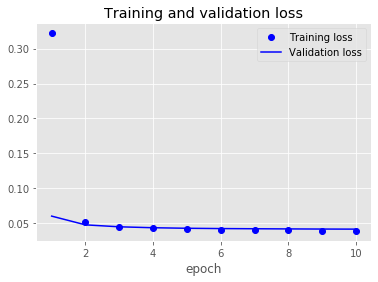

In [82]:
plot_training_history(history)

**2.2a** Explain what the embedding layer is and why we need it here.

*your answer here*


**2.2b** Explain why the Param # of Embedding layer is 1758950 (as shown in `print(model.summary())`).

*your answer here*

### Viewing Hidden Layers
In addition to the final result, we also want to see the intermediate results from hidden layers. Below is an example showing how to get outputs from a hidden layer, and visualize them on the reduced dimension of 2D by PCA. (**Please note that this code and the parameters cannot be simply copied and pasted for other questions; some adjustments need to be made**) 

In [83]:
FFNN = load_keras_model("model_FFNN")
def create_truncated_model_FFNN(trained_model):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
    model.add(tf.keras.layers.Dropout(drop_rate))
    # set weights of first few layers using the weights of trained model
    for i, layer in enumerate(model.layers):
        layer.set_weights(trained_model.layers[i].get_weights())
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model
truncated_model = create_truncated_model_FFNN(FFNN)
hidden_features = truncated_model.predict(X_te)

# flatten data
hidden_features = hidden_features.reshape(-1,50)
 
# find first two PCA components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(hidden_features)
print('Variance explained by PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))

Variance explained by PCA: 0.9283624230366543


In [84]:
# visualize hidden featurs on first two PCA components
# this plot only shows B-tags
def visualize_hidden_features(pca_result):
    color=['r', 'C1', 'y', 'C3', 'b', 'g', 'm', 'orange']
    category = np.argmax(y_te, axis=1)
    fig, ax = plt.subplots()
    fig.set_size_inches(6,6)    
    for cat in range(8):
        indices_B = np.where(category==cat)[0]
        #length=min(1000,len(indices_B))
        #indices_B=indices_B[:length]
        ax.scatter(pca_result[indices_B,0], pca_result[indices_B, 1], label=idx2tag[cat],s=2,color=color[cat],alpha=0.5)
        legend=ax.legend(markerscale=3)
        legend.get_frame().set_facecolor('w')  
    plt.show()

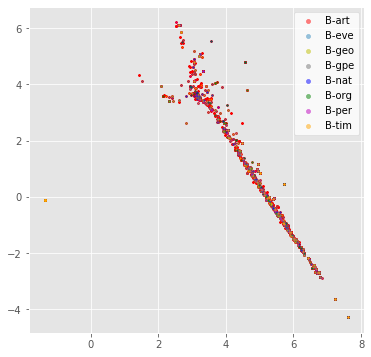

In [85]:
visualize_hidden_features(pca_result)

### Full function for other questions ###

In [86]:
def get_hidden_output_PCA(model,X_te,y_te,layer_index,out_dimension):
    output = tf.keras.backend.function([model.layers[0].input],[model.layers[layer_index].output])
    hidden_feature=np.array(output([X_te]))
    hidden_feature=hidden_feature.reshape(-1,out_dimension)
    
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(hidden_feature)
    print('Variance explained by PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))
    return pca_result

In [87]:
def visualize_B_I(pca_result):
    color = ['r', 'C1', 'y', 'C3', 'b', 'g', 'm', 'orange']
    category = np.argmax(y_te.reshape(-1,18), axis=1)
    fig, ax = plt.subplots(1,2) 
    fig.set_size_inches(12,6)
    for i in range(2):
        for cat in range(8*i,8*(i+1)):
            indices = np.where(category==cat)[0]
            ax[i].scatter(pca_result[indices,0], pca_result[indices, 1], label=idx2tag[cat],s=2,color=color[cat-8*i],alpha=0.5)
        legend = ax[i].legend(markerscale=3)
        legend.get_frame().set_facecolor('w') 
        ax[i].set_xlabel("first dimension")
        ax[i].set_ylabel("second dimension")
    fig.suptitle("visualization of hidden feature on reduced dimension by PCA")
    
    plt.show()

Variance explained by PCA: 0.9283737427861207


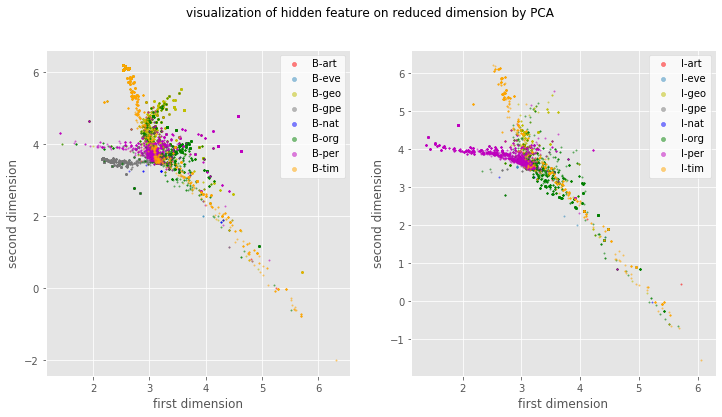

In [88]:
h = get_hidden_output_PCA(FFNN,X_te,y_te,1,50)
visualize_B_I(h)

**2.3** **Model 3: RNN**

Set up a simple RNN model by stacking the following layers in sequence:

    an input layer
    a simple Embedding layer transforming integer words into vectors
    a dropout layer to regularize the model
    a SimpleRNN layer
    a TimeDistributed layer with an inner Dense layer which output dimensionality is equal to n_tag
    
*(For hyperparameters, use those provided in Model 2)*

**2.3a** Define, compile, and train an RNN model. Use the provided code to save the model and plot the training history.

In [89]:
# for reference - delete before submission

n_units = 100
drop_rate = .1
dim_embed = 50

optimizer = "rmsprop"
loss = "categorical_crossentropy"
metrics = ["accuracy"]

batch_size = 32
epochs = 10
validation_split = 0.1
verbose = 1

In [90]:
# define model
model = Sequential()
model.add(Embedding(input_dim = n_words, output_dim = dim_embed, input_length = max_len))
model.add(Dropout(drop_rate))
model.add(SimpleRNN(100, return_sequences = True))
model.add(TimeDistributed(Dense(n_tags, activation = 'softmax')))

# compile model
model.compile(optimizer = optimizer, loss = loss, metrics = metrics )

In [91]:
# Train model
history = model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

Train on 38846 samples, validate on 4317 samples
Epoch 1/10
38846/38846 [==============================] - 79s 2ms/sample - loss: 0.0927 - accuracy: 0.9766 - val_loss: 0.0328 - val_accuracy: 0.9903
Epoch 2/10
38846/38846 [==============================] - 77s 2ms/sample - loss: 0.0295 - accuracy: 0.9912 - val_loss: 0.0288 - val_accuracy: 0.9914
Epoch 3/10
38846/38846 [==============================] - 76s 2ms/sample - loss: 0.0263 - accuracy: 0.9922 - val_loss: 0.0281 - val_accuracy: 0.9917
Epoch 4/10
38846/38846 [==============================] - 77s 2ms/sample - loss: 0.0245 - accuracy: 0.9927 - val_loss: 0.0270 - val_accuracy: 0.9920
Epoch 5/10
38846/38846 [==============================] - 77s 2ms/sample - loss: 0.0233 - accuracy: 0.9930 - val_loss: 0.0271 - val_accuracy: 0.9920
Epoch 6/10
38846/38846 [==============================] - 77s 2ms/sample - loss: 0.0223 - accuracy: 0.9933 - val_loss: 0.0266 - val_accuracy: 0.9921
Epoch 7/10
38846/38846 [==============================] -

In [92]:
# save your mode #
store_keras_model(model, 'model_RNN')

Saved model to disk


In [93]:
# run this cell to show your results #
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_4 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 104, 100)          15100     
_________________________________________________________________
time_distributed (TimeDistri (None, 104, 18)           1818      
Total params: 1,775,868
Trainable params: 1,775,868
Non-trainable params: 0
_________________________________________________________________
None


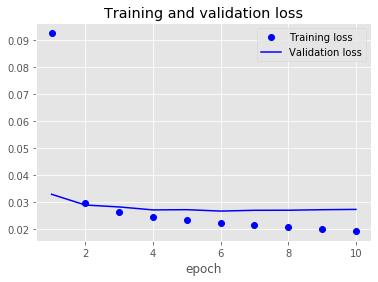

In [94]:
# run this cell to show your results #
plot_training_history(history)

**2.3b** Visualize outputs from the SimpleRNN layer, one subplot for B-tags and one subplot for I-tags. Comment on the patterns you observed.

Variance explained by PCA: 0.9753719737319427


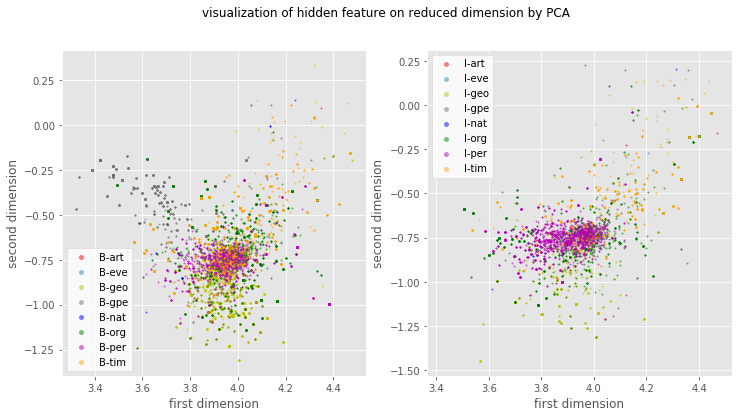

In [96]:
FFNN = load_keras_model("model_RNN")

h = get_hidden_output_PCA(FFNN,X_te,y_te,1,50)
visualize_B_I(h)

<div class='explication'> </div>

**2.4** **Model 4: GRU**

**2.4a** Briefly explain what a GRU is and how it's different from a simple RNN.

*your answer here*


**2.4b** Define, compile, and train a GRU architecture by replacing the SimpleRNN cell with a GRU one. Use the provided code to save the model and plot the training history.

In [97]:
# for reference - delete before submission

n_units = 100
drop_rate = .1
dim_embed = 50

optimizer = "rmsprop"
loss = "categorical_crossentropy"
metrics = ["accuracy"]

batch_size = 32
epochs = 10
validation_split = 0.1
verbose = 1

In [98]:
# define model
model = Sequential()
model.add(Embedding(input_dim = n_words, output_dim = dim_embed, input_length = max_len))
model.add(Dropout(drop_rate))
model.add(GRU(100, return_sequences = True))
model.add(TimeDistributed(Dense(n_tags, activation = 'softmax')))

# compile model
model.compile(optimizer = optimizer, loss = loss, metrics = metrics )

In [99]:
# Train model
history = model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

Train on 38846 samples, validate on 4317 samples
Epoch 1/10
38846/38846 [==============================] - 42s 1ms/sample - loss: 0.0888 - accuracy: 0.9774 - val_loss: 0.0325 - val_accuracy: 0.9903
Epoch 2/10
38846/38846 [==============================] - 37s 949us/sample - loss: 0.0291 - accuracy: 0.9914 - val_loss: 0.0283 - val_accuracy: 0.9916
Epoch 3/10
38846/38846 [==============================] - 37s 950us/sample - loss: 0.0259 - accuracy: 0.9923 - val_loss: 0.0269 - val_accuracy: 0.9920
Epoch 4/10
38846/38846 [==============================] - 37s 943us/sample - loss: 0.0240 - accuracy: 0.9928 - val_loss: 0.0261 - val_accuracy: 0.9922
Epoch 5/10
38846/38846 [==============================] - 37s 950us/sample - loss: 0.0228 - accuracy: 0.9932 - val_loss: 0.0260 - val_accuracy: 0.9923
Epoch 6/10
38846/38846 [==============================] - 37s 942us/sample - loss: 0.0219 - accuracy: 0.9934 - val_loss: 0.0254 - val_accuracy: 0.9923
Epoch 7/10
38846/38846 [=======================

In [100]:
# save your model #
store_keras_model(model, 'model_GRU')

Saved model to disk


In [101]:
# run this cell to show your results #
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_5 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
gru (GRU)                    (None, 104, 100)          45600     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 104, 18)           1818      
Total params: 1,806,368
Trainable params: 1,806,368
Non-trainable params: 0
_________________________________________________________________
None


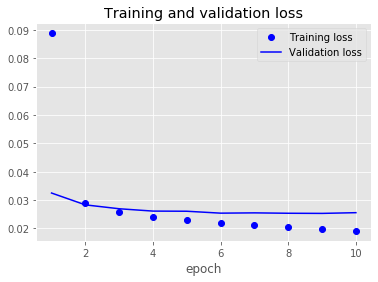

In [102]:
# run this cell to show your results #
plot_training_history(history)

**2.4c** Visualize outputs from GRU layer, one subplot for **B-tags** and one subplot for **I-tags**. Comment on the patterns you observed.

Variance explained by PCA: 0.9709314330321844


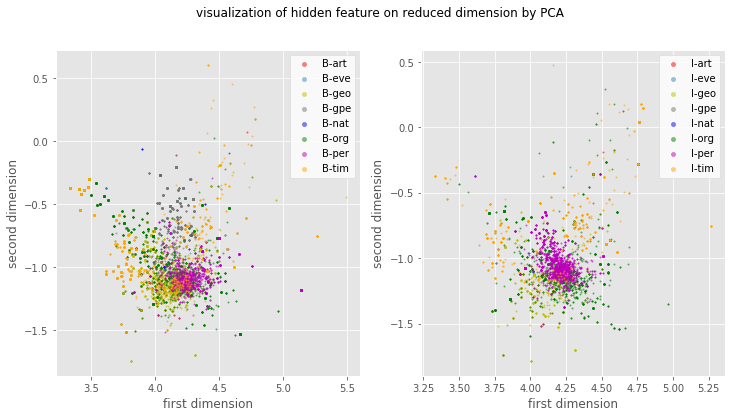

In [103]:
FFNN = load_keras_model("model_GRU")

h = get_hidden_output_PCA(FFNN,X_te,y_te,1,50)
visualize_B_I(h)

*your answer here*

**2.5** **Model 5: Bidirectional GRU**

**2.5a** Explain how a Bidirectional GRU differs from GRU model above.



*your answer here*

**2.5b** Define, compile, and train a bidirectional GRU by wrapping your GRU layer in a Bidirectional one. Use the provided code to save the model and plot the training history.


In [104]:
# for reference - delete before submission

n_units = 100
drop_rate = .1
dim_embed = 50

optimizer = "rmsprop"
loss = "categorical_crossentropy"
metrics = ["accuracy"]

batch_size = 32
epochs = 10
validation_split = 0.1
verbose = 1

In [105]:
# define model
model = Sequential()
model.add(Embedding(input_dim = n_words, output_dim = dim_embed, input_length = max_len))
model.add(Dropout(drop_rate))
model.add(Bidirectional(GRU(100, return_sequences = True)))
model.add(TimeDistributed(Dense(n_tags, activation = 'softmax')))

# compile model
model.compile(optimizer = optimizer, loss = loss, metrics = metrics )

In [106]:
# Train model
history = model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

Train on 38846 samples, validate on 4317 samples
Epoch 1/10
38846/38846 [==============================] - 73s 2ms/sample - loss: 0.0704 - accuracy: 0.9828 - val_loss: 0.0283 - val_accuracy: 0.9917
Epoch 2/10
38846/38846 [==============================] - 68s 2ms/sample - loss: 0.0242 - accuracy: 0.9929 - val_loss: 0.0239 - val_accuracy: 0.9929
Epoch 3/10
38846/38846 [==============================] - 68s 2ms/sample - loss: 0.0208 - accuracy: 0.9939 - val_loss: 0.0229 - val_accuracy: 0.9932
Epoch 4/10
38846/38846 [==============================] - 68s 2ms/sample - loss: 0.0189 - accuracy: 0.9944 - val_loss: 0.0219 - val_accuracy: 0.9934
Epoch 5/10
38846/38846 [==============================] - 68s 2ms/sample - loss: 0.0175 - accuracy: 0.9948 - val_loss: 0.0218 - val_accuracy: 0.9935
Epoch 6/10
38846/38846 [==============================] - 68s 2ms/sample - loss: 0.0164 - accuracy: 0.9951 - val_loss: 0.0215 - val_accuracy: 0.9935
Epoch 7/10
38846/38846 [==============================] -

In [107]:
# save your model #
store_keras_model(model, 'model_BiGRU')

Saved model to disk


In [108]:
# run this cell to show your results #
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_6 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 104, 200)          91200     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 104, 18)           3618      
Total params: 1,853,768
Trainable params: 1,853,768
Non-trainable params: 0
_________________________________________________________________
None


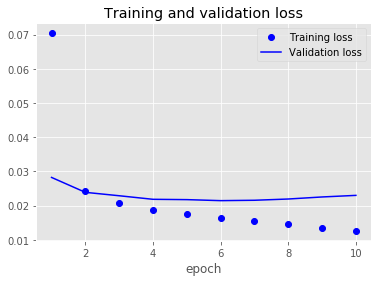

In [109]:
# run this cell to show your results #
plot_training_history(history)

**2.5c** Visualize outputs from bidirectional GRU layer, one subplot for **B-tags** and one subplot for **I-tags**. Comment on the patterns you observed.

Variance explained by PCA: 0.8601694191654763


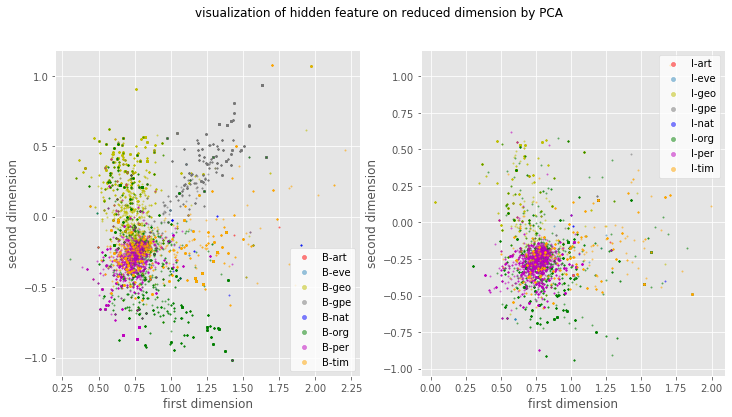

In [110]:
FFNN = load_keras_model("model_BiGRU")

h = get_hidden_output_PCA(FFNN,X_te,y_te,1,50)
visualize_B_I(h)

*your answer here*

<div class='exercise'><b> Question 3: Analysis [40pt]</b></div>


**3.1** For each model, iteratively:

- Load the model using the given function ```load_keras_model```

- Apply the model to the test dataset

- Compute an F1 score for each ```Tag``` and store it 

**3.2** Plot the F1 score per Tag and per model making use of a grouped barplot.

**3.3** Briefly discuss the performance of each model


**3.4** Which tags have the lowest f1 score? For instance, you may find from the plot above that the test accuracy on "B-art", and "I-art" are very low (just an example, your case maybe different). Here is an example when models failed to predict these tags right

<img src="data/B_art.png" alt="drawing" width="600"/>

**3.5** Write functions to output another example in which the tags of the lowest accuracy was predicted wrong in a sentence (include both "B-xxx" and "I-xxx" tags). Store the results in a DataFrame (same format as the above example) and use styling functions below to print out your df.

**3.6** Choose one of the most promising models you have built, improve this model to achieve an f1 score higher than 0.8 for as many tags as possible (you have lots of options here, e.g. data balancing, hyperparameter tuning, changing the structure of NN, a different optimizer, etc.)

**3.7** Explain why you chose to change certain elements of the model and how effective these adjustments were.


## Answers

**3.1** For each model, iteratively:

- Load the model using the given function ```load_keras_model```

- Apply the model to the test dataset

- Compute an F1 score for each ```Tag``` and store it 

In [ ]:
# your code here


**3.2** Plot the F1 score per Tag and per model making use of a grouped barplot.

In [ ]:
# your code here


**3.3** Briefly discuss the performance of each model

*your answer here*


**3.4** Which tags have the lowest f1 score? For instance, you may find from the plot above that the test accuracy on "B-art", and "I-art" are very low (just an example, your case maybe different). Here is an example when models failed to predict these tags right

<img src="data/B_art.png" alt="drawing" width="600"/>

*your answer here*


**3.5** Write functions to output another example in which the tags of the lowest accuracy was predicted wrong in a sentence (include both "B-xxx" and "I-xxx" tags). Store the results in a DataFrame (same format as the above example) and use styling functions below to print out your df.

In [ ]:
def highlight_errors(s):
    is_max = s == s.y_true
    return ['' if v or key=='Word' else 'color: red' for key,v in is_max.iteritems()]

In [ ]:
# your code here


In [ ]:
# your code here


In [ ]:
# your code here


**3.6** Choose one of the most promising models you have built, improve this model to achieve an f1 score higher than 0.8 for as many tags as possible (you have lots of options here, e.g. data balancing, hyperparameter tuning, changing the structure of NN, a different optimizer, etc.)

In [ ]:
# your code here


**3.7** Explain why you chose to change certain elements of the model and how effective these adjustments were.

*your answer here*